# Tensorflow Model One

In [1]:
!pip install joblib

## Steps:
1. Load/Import Dependencies
- Load Paths
- Create tensflow datasets
2. Create training(80%), testing(10%) and validating(10%)
3. Build / Define the Model
4. Train the Model
-  Save the History Callback Object
5. Evaluate Model
- Model Loss Graph
- Model Accuracy Graph
6.  Make and Evaluate New Predictions Using Our Testing Data
7. Confusion  Matrix
- Checking Our Scores
- Classification Report

# 1. Load/Import Dependencies

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# # MAKING SURE WE ARE USING GPU
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [4]:
import tensorflow as tf  #Our model framework
import os # Working with files
import pandas as pd #To create/manipulate a dataframe
import numpy as np # Data wrangling.
import joblib # save scaler

# Evaluating Model
from sklearn.preprocessing import StandardScaler # To perform standardization by centering and scaling.
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, f1_score, multilabel_confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

# Building the model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers                  # Keras layers API.
from tensorflow.keras.layers import Conv1D, Dense, Flatten # Conv2D is a convolution neural network. Flatten is to make everything into one dimensional
from tensorflow.keras.callbacks import EarlyStopping     # Stop training when a monitored metric has stopped improving.
from sklearn.model_selection import train_test_split # To split data in training/validating/testing.
from tensorflow.keras.callbacks import ReduceLROnPlateau # Reduce learning rate when a metric has stopped improving.
from tensorflow.keras.models import load_model           # To load the model.
import pickle # Python object serialization.

#  Visualise Model Performance
import seaborn as sns
sns.set()
import plotly.express as px
from matplotlib import pyplot as plt

# # Hugging Face
# from huggingface_hub import from_pretrained_keras

In [5]:
model_OG = load_model('/content/drive/MyDrive/data/model/model.21-main1234/')

## 1.1 Loading data path

In [6]:
csv_features_combined = os.path.join('/content/drive/MyDrive/data/features/new_features_5k/features_combined_5.csv')

## 1.2 Making csv files dataframes

In [7]:
df_features_combined = pd.read_csv(csv_features_combined)

## 1.3 Null Values

In [8]:
df_features_combined.isnull().sum().sum()

4770888

In [9]:
df_features_combined = df_features_combined.fillna(0)

In [10]:
df_features_combined.isnull().sum().sum()

0

# 2. Create training, testing and validating

## 2.1 Split Our Data Into Three Sets:
> 1. Training   (80%)
> 2. Validating (10%)
> 3. Testing    (10%)

In [11]:
X = df_features_combined.drop(labels=['label'], axis=1)
y = df_features_combined['label']


In [12]:
X_train, X_remain, y_train, y_remain = train_test_split(
    X, y, test_size = 0.2, random_state = 42)

print('X_remain.shape = ', X_remain.shape)
print('y_remain.shape = ', y_remain.shape)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_remain, y_remain, test_size = 0.5, random_state = 42)

print('X_train.shape  = ', X_train.shape)
print('y_train.shape  = ', y_train.shape)
print('X_valid.shape  = ', X_valid.shape)
print('y_valid.shape  = ', y_valid.shape)
print('X_test.shape   = ', X_test.shape)
print('y_test.shape   = ', y_test.shape)

X_remain.shape =  (8921, 2592)
y_remain.shape =  (8921,)
X_train.shape  =  (35683, 2592)
y_train.shape  =  (35683,)
X_valid.shape  =  (4460, 2592)
y_valid.shape  =  (4460,)
X_test.shape   =  (4461, 2592)
y_test.shape   =  (4461,)


In [13]:
# Standardize / Scale data.
# Standardize features by removing the mean and scaling to unit variance.
# z = (x - u) / s

standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train.values)
X_valid = standard_scaler.transform(X_valid.values)
X_test = standard_scaler.transform(X_test.values)

print('X_train.shape  = ', X_train.shape)
print('X_remain.shape = ', X_remain.shape)
print('X_valid.shape  = ', X_valid.shape)
print('X_test.shape   = ', X_test.shape)


X_train.shape  =  (35683, 2592)
X_remain.shape =  (8921, 2592)
X_valid.shape  =  (4460, 2592)
X_test.shape   =  (4461, 2592)


In [14]:
# Modify data to fit into a 1D-CNN.

X_train = np.expand_dims(X_train, axis = 2)
X_valid = np.expand_dims(X_valid, axis = 2)
X_test = np.expand_dims(X_test, axis = 2)

print('X_train.shape  = ', X_train.shape)
print('X_remain.shape = ', X_remain.shape)
print('X_valid.shape  = ', X_valid.shape)
print('X_test.shape   = ', X_test.shape)

X_train.shape  =  (35683, 2592, 1)
X_remain.shape =  (8921, 2592)
X_valid.shape  =  (4460, 2592, 1)
X_test.shape   =  (4461, 2592, 1)


# 3. Build / Define the Model

In [15]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               patience = 10,
                               mode = 'auto',
                               restore_best_weights = True)

In [16]:
reduce_learning_rate = ReduceLROnPlateau(monitor ='val_accuracy',
                                         factor = 0.5,
                                         verbose = 1,
                                         min_lr = 0.00001)

In [17]:
checkpoint_filepath = '/content/drive/MyDrive/data/model/checkpoints'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# 4. Train the Model

In [18]:
amount = len(df_features_combined)
batch_size = int(round((amount) * 0.02))
print("batchsize: ",batch_size)
prefetech = round(batch_size / 2)
print("prefetech: ",prefetech)


batchsize:  892
prefetech:  446


In [19]:
history_callback_object = model_OG.fit(
    x = X_train, y = tf.cast(y_train, tf.float32), batch_size = 256,
    epochs = 5000, verbose = 2,
    shuffle = True,
    callbacks = [early_stopping, reduce_learning_rate, model_checkpoint_callback],
    validation_data = ( X_valid, tf.cast(y_valid, tf.float32) ))

Epoch 1/5000
140/140 - 52s - loss: 0.0027 - accuracy: 0.9990 - val_loss: 0.0032 - val_accuracy: 0.9991 - lr: 6.2500e-05 - 52s/epoch - 372ms/step
Epoch 2/5000
140/140 - 36s - loss: 8.2368e-04 - accuracy: 0.9997 - val_loss: 0.0015 - val_accuracy: 0.9993 - lr: 6.2500e-05 - 36s/epoch - 258ms/step
Epoch 3/5000
140/140 - 36s - loss: 5.0039e-04 - accuracy: 0.9999 - val_loss: 0.0018 - val_accuracy: 0.9991 - lr: 6.2500e-05 - 36s/epoch - 257ms/step
Epoch 4/5000
140/140 - 36s - loss: 1.9140e-04 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 0.9993 - lr: 6.2500e-05 - 36s/epoch - 257ms/step
Epoch 5/5000
140/140 - 36s - loss: 1.4136e-04 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 0.9996 - lr: 6.2500e-05 - 36s/epoch - 259ms/step
Epoch 6/5000
140/140 - 36s - loss: 2.6298e-04 - accuracy: 0.9999 - val_loss: 0.0019 - val_accuracy: 0.9993 - lr: 6.2500e-05 - 36s/epoch - 257ms/step
Epoch 7/5000
140/140 - 36s - loss: 9.0220e-04 - accuracy: 0.9997 - val_loss: 0.0026 - val_accuracy: 0.9991 - l

In [20]:
print(model_OG.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 519, 1024)         6144      
                                                                 
 batch_normalization (Batch  (None, 519, 1024)         4096      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 173, 1024)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 35, 512)           2621952   
                                                                 
 batch_normalization_1 (Bat  (None, 35, 512)           2048      
 chNormalization)                                                
                                                        

## 4.1 To save history callback object

In [21]:
file_path_history_callback_object = '\content\drive\MyDrive\data\model.21-main12345'

with open(file_path_history_callback_object, 'wb') as history_callback_object_file:
    pickle.dump(history_callback_object.history, history_callback_object_file)

# This is used to load the history_callback_object whenever necessary.
# with open(file_path_history_callback_object, 'rb') as history_callback_object_file:
#     history_callback_object = pickle.load(history_callback_object_file)

In [22]:
file_path_model = '/content/drive/MyDrive/data/model/model.21-main12345'

model_OG.save(file_path_model)

```Save Scaler Model```

In [23]:
joblib.dump(standard_scaler, "/content/drive/MyDrive/data/scaler model/standard_scaler21-main12345.save")

['/content/drive/MyDrive/data/scaler model/standard_scaler21-main12345.save']

# 5. Evaluate Model

In [24]:
fig = px.line(data_frame = history_callback_object.history,
              y = ['loss', 'val_loss'],
              labels = {'index':'Epoch', 'value':'Loss'},
              title = 'Loss vs Epoch')
fig.show()

history_callback_object.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [25]:
fig = px.line(data_frame = history_callback_object.history,
              y = ['accuracy', 'val_accuracy'],
              labels = {'index':'Epoch', 'value':'Accuracy'},
              title = 'Accuracy vs Epoch')
fig.show()

history_callback_object.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

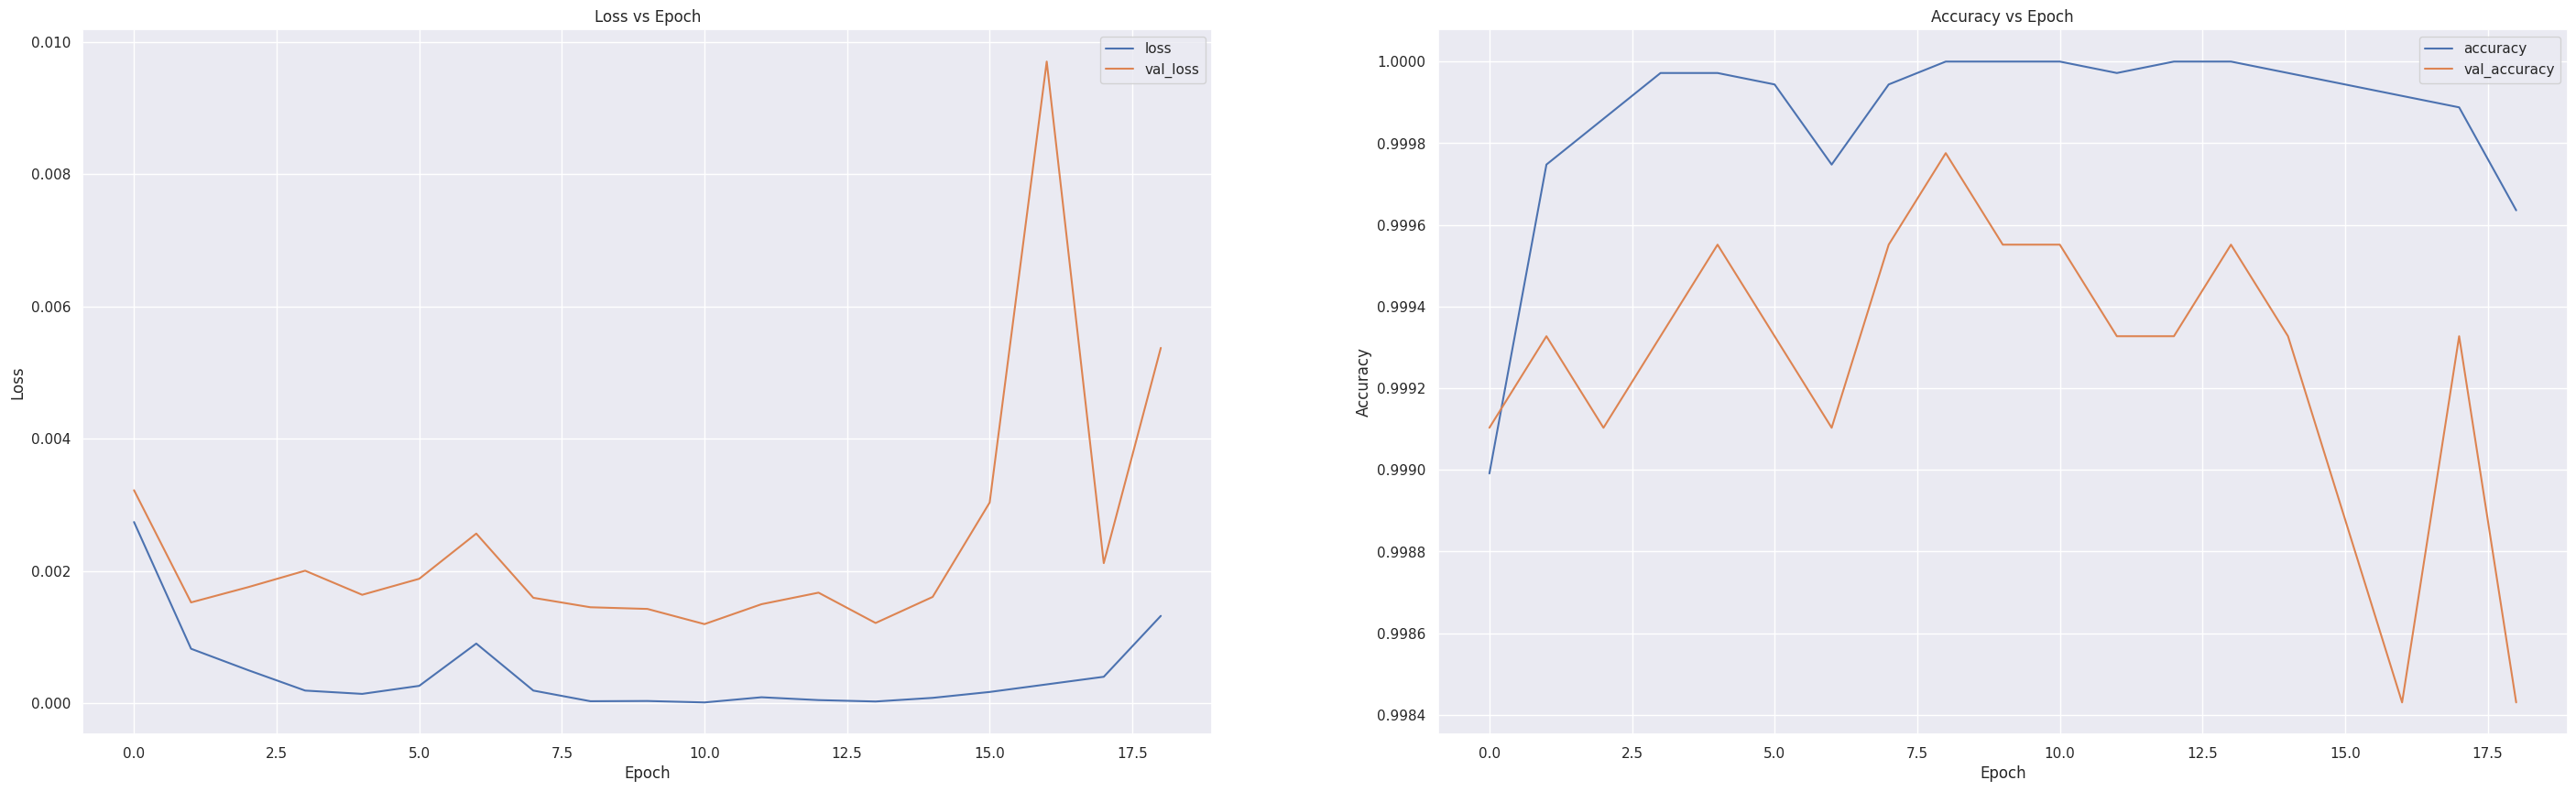

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history_callback_object.history['loss'], label = 'loss')
ax1.plot(history_callback_object.history['val_loss'], label = 'val_loss')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss vs Epoch')
ax1.grid(True)

ax2.plot(history_callback_object.history['accuracy'], label = 'accuracy')
ax2.plot(history_callback_object.history['val_accuracy'], label = 'val_accuracy')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs Epoch')
ax2.grid(True)

fig.set_figheight(10)
fig.set_figwidth(35)
plt.show()

history_callback_object.history.keys()

# 6. Make and Evaluate New Predictions Using Our Testing Data

In [27]:
# df_features_combined_matrix['label_name'] = True if df_features_combined_matrix['label'] == 1 else False
df_features_combined['label_name'] = df_features_combined['label'].astype(bool)

df_features_combined_matrix = sorted(df_features_combined['label_name'].unique())
print(df_features_combined_matrix)

[False, True]


In [28]:
y_pred = model_OG.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1)
y_true = y_test

y_pred = tf.round(y_pred)
y_pred = y_pred.numpy()

140/140 [==============================] - 2s 10ms/step


# 7. Confusion Matrix

       False  True 
False   2160      0
True       2   2299 





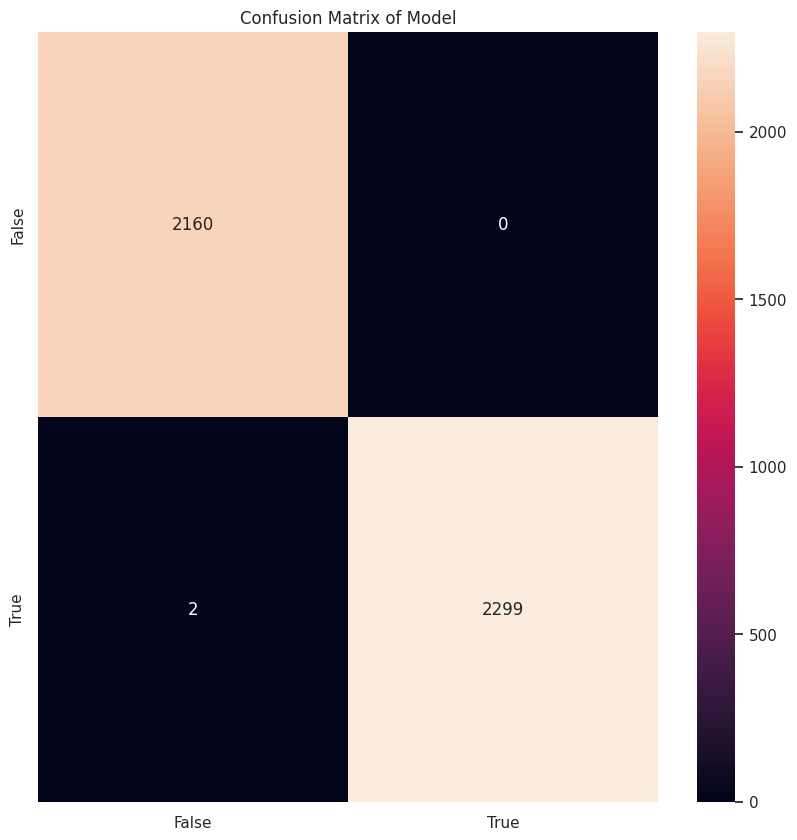

In [29]:
fig = plt.figure(figsize=(10, 10))
plt.title('Confusion Matrix of Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')


model_matrix = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(model_matrix,
                  index = [i for i in df_features_combined_matrix ],
                  columns = [i for i in df_features_combined_matrix ]
                 )

# index = index[:2]
# columns = columns[:2]

# cm = cm.reindex(index=df_features_combined, columns=df_features_combined)




ax = sns.heatmap(cm,
                 annot = True,
                 fmt = 'd',cbar=True)

print(cm, '\n\n\n')

plt.show()

## 7.1 Checking Our Scores

In [30]:
model_loss, model_accuracy = model_OG.evaluate(X_test, y_test)

print('Model Test Loss: %f' % (model_loss))
print('Model Test Loss: %f' % (model_loss * 100), '%\n', sep = '')
print('Model Test Accuracy: %f' % (model_accuracy))
print('Model Test Accuracy: %f' % (model_accuracy * 100), '%', sep = '')

140/140 [==============================] - 2s 11ms/step - loss: 0.0029 - accuracy: 0.9996
Model Test Loss: 0.002890
Model Test Loss: 0.288983%

Model Test Accuracy: 0.999552
Model Test Accuracy: 99.955165%


In [31]:
# Calculate our accuracy score.
accuracy = accuracy_score(y_true, y_pred)

# Calculate our precision score.
precision = precision_score(y_true, y_pred, average = 'micro')

# Calculate our recall score.
recall = recall_score(y_true, y_pred, average = 'micro')

# Calculate our f1-score.
f1 = f1_score(y_true, y_pred, average = 'micro')

# Print each of our scores to inspect performance.
print('Accuracy Score: %f' % (accuracy * 100), '%', sep = '')
print('Precision Score: %f' % (precision * 100), '%', sep = '')
print('Recall Score: %f' % (recall * 100), '%', sep = '')
print('F1 Score: %f' % (f1 * 100), '%', sep = '')


Accuracy Score: 99.955167%
Precision Score: 99.955167%
Recall Score: 99.955167%
F1 Score: 99.955167%
